# Kalman Filter OLS on OU process
Test our own Kalman Filter implementation named "Skalman" and validate against off the shelf pykalman.

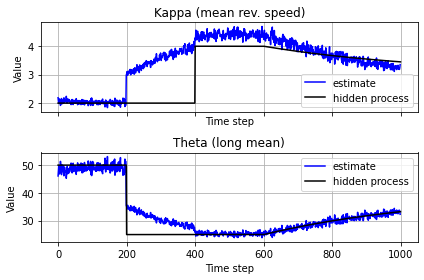

In [1]:
import numpy as np
import pandas as pd
import pykalman
from scipy import stats
import matplotlib.pyplot as plt
from src.skalman import Skalman
import src.stochproc as stochproc

def vol(t):
    return 0.2

def long_mean(t):
    if t < 200:
        return 50
    elif t < 600:
        return 25
    else:
        return 40-(40-25)*np.exp(-(t-600)/500)

def decay_speed(t):
    if t < 400:
        return 2.0
    elif t < 600:
        return 4.0
    else:
        return 3-(3-4)*np.exp(-(t-600)/500)


def kalman_OU_ols():
    dt = 1.0 / 250.0
    sample_size = 1000

    # ===== Generate Process =====
    innovation = stochproc.ou(40, decay_speed, long_mean, vol, dt, sample_size)
    y = innovation[1::] # Reponse variable y(t) in state transition AR(1) model: y(t) = y(t-1) + noise.
    x = innovation[:-1] # Explanatory variable y(t-1) in state transition AR(1) model: y(t) = y(t-1) + noise.

    # ===== Transition input =====
    # AR(1) or random walk assumption on state transition.
    transition_matrices = np.eye(2)
    # Noise for the AR(1) process. TODO: corr between state variables <=> corr(alpha, beta) is negative in OLS, maybe use this?
    transition_covariance = np.eye(2)
    
    # ===== Measurement input =====
    # Observation matrix, mapping y(t-1) -> y(t): y(t)
    observation_matrices = np.vstack([np.ones(x.shape), x]).T[:, np.newaxis]
    # Obs_cov is the stoch part in the OU solution <=> or noise term in the OLS.
    kappa_guess = 1.0; sigma_guess = 0.1
    observation_covariance = np.array([ sigma_guess**2 * ((1-np.exp(-2*kappa_guess*dt))/(2*kappa_guess)) ])

    # ===== Initial State guess =====
    # Some reasonable start guess...
    initial_state_mean = np.array([0.25, 0.75])
    # Some large covariance, sice we have no idea...
    initial_state_covariance = np.ones((2, 2))

    # ===== Perform Kalman filtering =====
    skalman = Skalman(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        transition_matrices=transition_matrices,
        observation_matrices=observation_matrices,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance)

    state_means, state_cov = skalman.filter(y)

    kf = pykalman.KalmanFilter(
                    n_dim_obs=1,
                    n_dim_state=2,
                    initial_state_mean=initial_state_mean,
                    initial_state_covariance=initial_state_covariance,
                    transition_matrices=transition_matrices,
                    observation_matrices=observation_matrices,
                    observation_covariance=observation_covariance,
                    transition_covariance=transition_covariance)

    state_means_pk, state_cov_pk = kf.filter(y)

    # Check that Skalman == pykalman
    uneqal = lambda arr1,arr2: np.max(np.abs(arr1 - arr2)) > 1E-10
    if uneqal(state_means, state_means_pk) or uneqal(state_cov, state_cov_pk):
        raise ValueError('Skalman not equal to pykalman')

    # Map OLS parameters to OU parameters.
    OU_param = np.asarray([list(stochproc.ols_to_ou_params(alpha, beta, dt)) for alpha,beta in state_means])

    def unbias(k, n, T, h):
        return k - 1/(2*T)*(3 + np.exp(2*k*h)) + 2*(1-np.exp(-2*n*k*h))/(T*n*(1-np.exp(-2*k*h)))
    
    # === Bias correction ===
    # Remark 2.3 @ https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=2151&context=soe_research
    #hh = np.arange(sample_size-1) + 1 # online
    #hh = sample_size
    OU_param[:,0] = unbias(OU_param[:,0], sample_size, sample_size*dt, dt)

    # Get hidden OU parameters used to generate OU process.
    kappa_exact = np.array([decay_speed(i) for i in range(sample_size)])
    theta_exact = np.array([long_mean(i) for i in range(sample_size)])

    # ===== Plotting =====
    fig, axs = plt.subplots(2,1, sharex=True)
    axs[0].plot(OU_param[:,0], 'b', label='estimate')
    axs[0].plot(kappa_exact, 'k', label='hidden process')
    axs[0].set_title('Kappa (mean rev. speed)')

    axs[1].plot(OU_param[:,1], 'b', label='estimate')
    axs[1].plot(theta_exact, 'k', label='hidden process')
    axs[1].set_title('Theta (long mean)')

    for ax in axs.flatten():
        ax.set_xlabel('Time step')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()
        
    fig.tight_layout()
    plt.show()



if __name__ == '_main_':
    kalman_OU_ols()

kalman_OU_ols()